In [41]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import seaborn.objects as so

## Overall GWP impacts

In [42]:
samples_combined_incl_total = pd.read_csv("results/samples_comparative_gwp_contributions.csv")
samples_combined =  samples_combined_incl_total[samples_combined_incl_total['component'] != 'Total']

# Flatten energy/device scenario combinations
samples_combined["combined_scenario"] = samples_combined["scenario"] + "\n" + samples_combined["energy_scenario"]

Show uncertainty in the full set of overall GWP results:

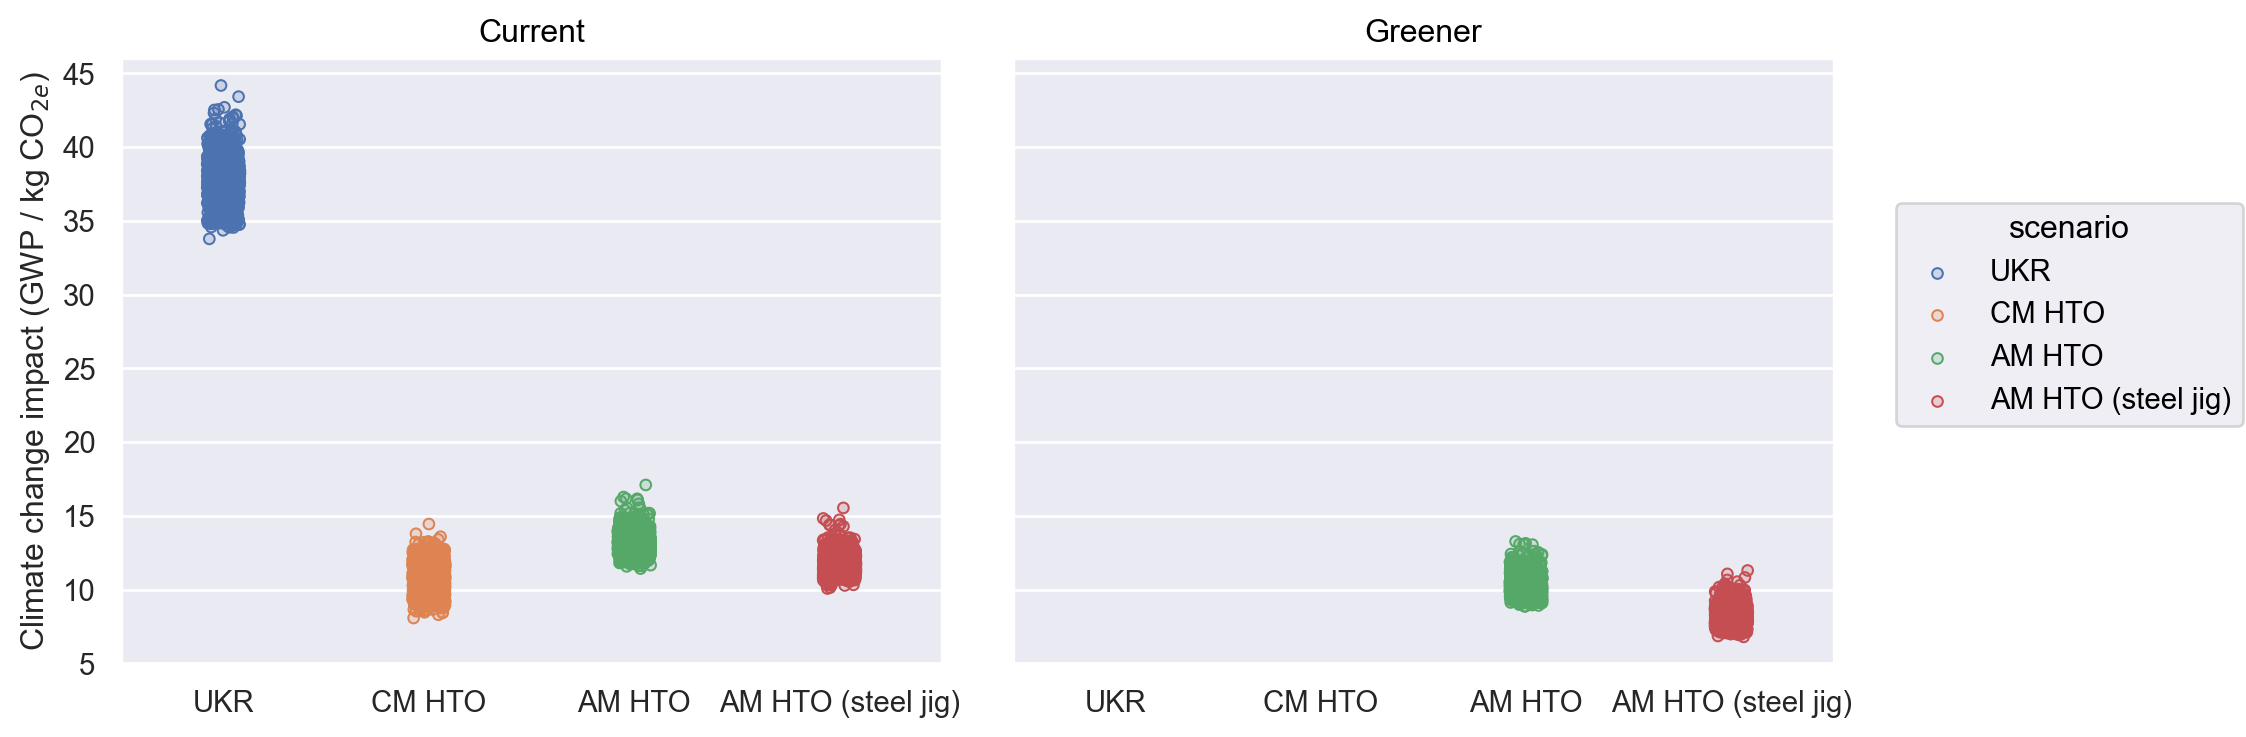

In [43]:
(
    so.Plot(samples_combined, x="scenario", y="score", color="scenario", group="iteration")
    .layout(size=(10, 4))
    .facet(col="energy_scenario")
    .add(so.Dots(), so.Agg("sum"), so.Jitter())
    .label(
        x="",
        y="Climate change impact (GWP / kg CO$_{2e}$)"
    )
)

Focus instead on the baseline results for the main UKR / CM HTO / AM HTO comparison:

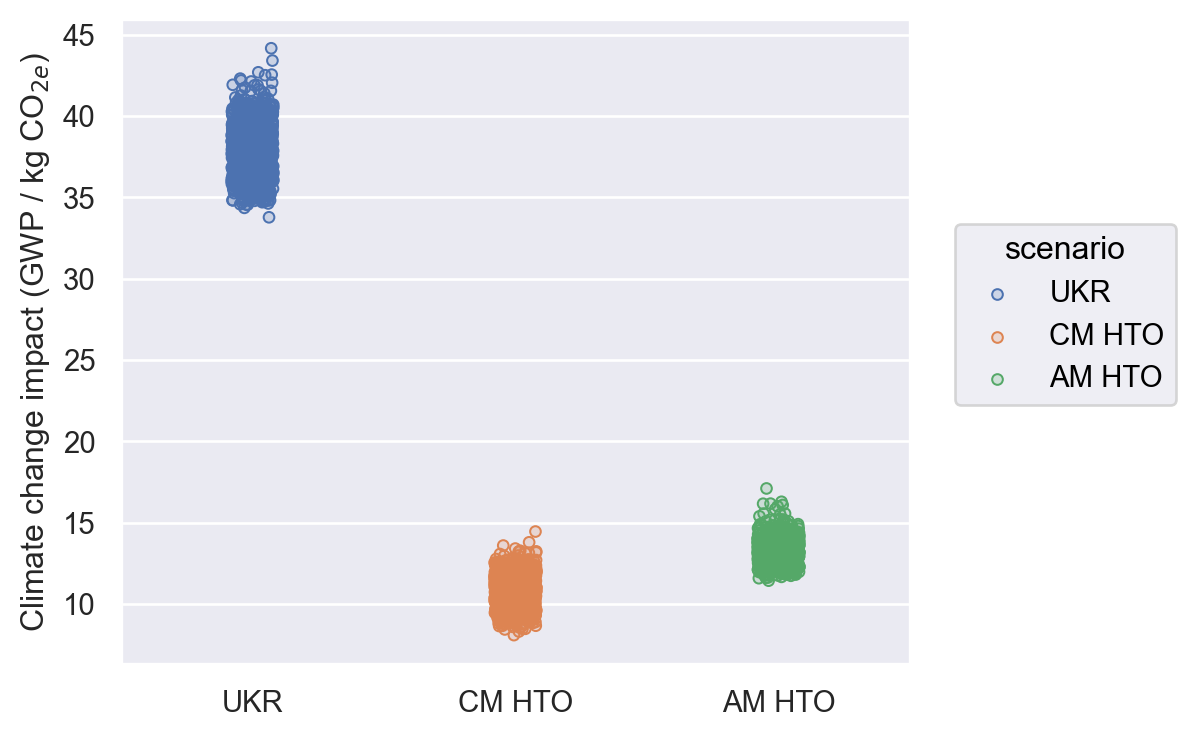

In [44]:
(
    so.Plot(samples_combined.query('scenario != "AM HTO (steel jig)" and energy_scenario == "Current"'),
            x="scenario", y="score", color="scenario", group="iteration")
    .layout(size=(5, 4))
    .add(so.Dots(), so.Agg("sum"), so.Jitter())
    .label(
        x="",
        y="Climate change impact (GWP / kg CO$_{2e}$)"
    )
    .save("figures/overall_gwp_comparison.pdf", bbox_inches=mpl.transforms.Bbox.from_extents(0, 0, 4.9, 4))
)

Variation on this -- include both the samples, and show contribution breakdown for the mean

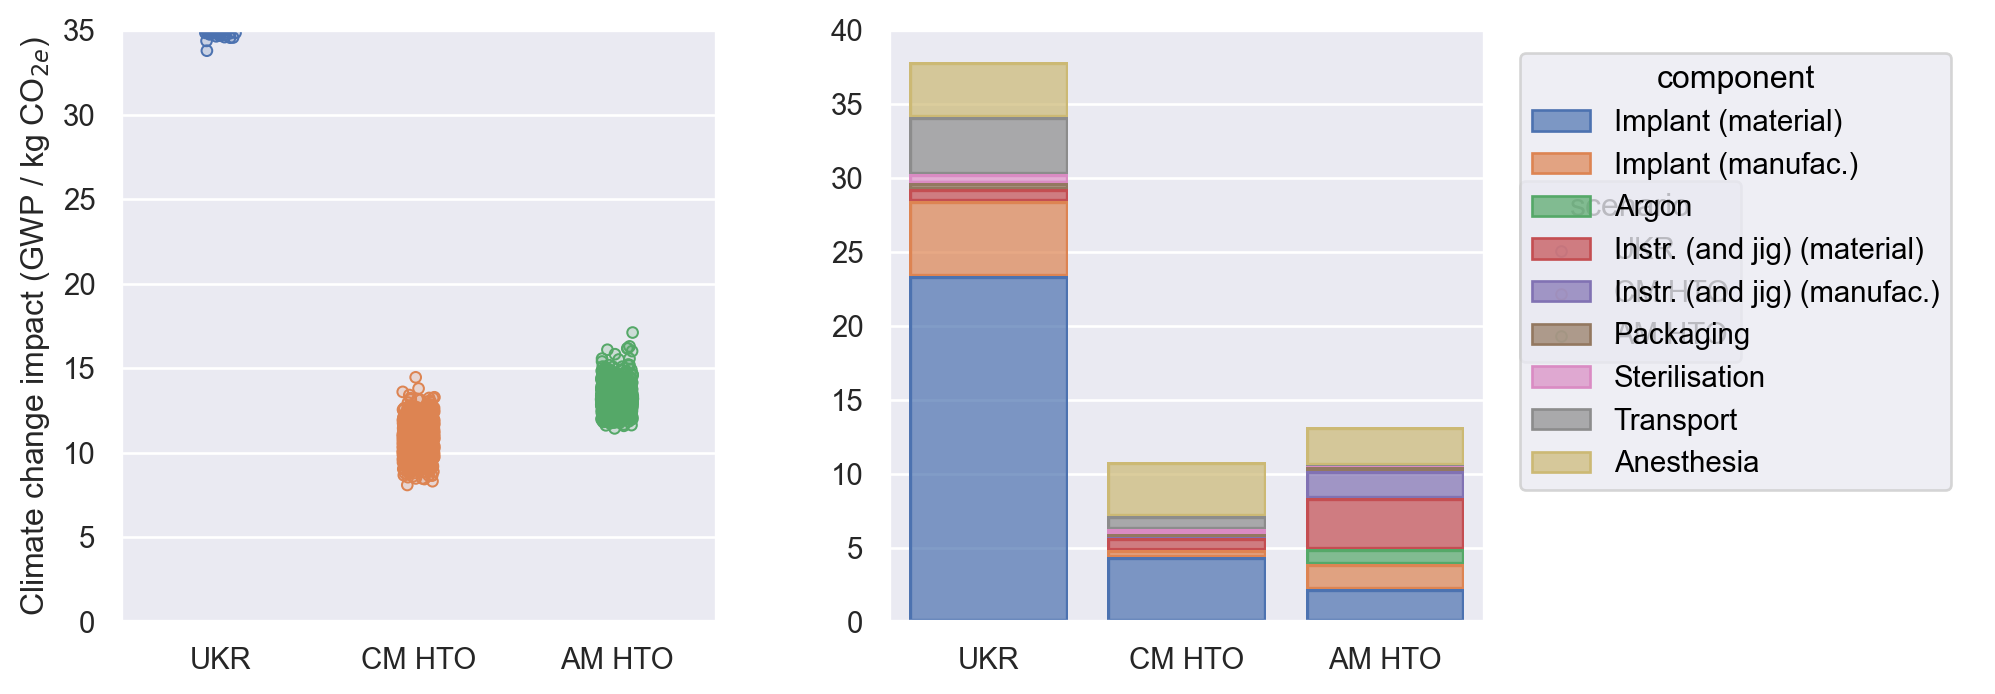

In [45]:
baseline = samples_combined.query('scenario != "AM HTO (steel jig)" and energy_scenario == "Current"')
baseline['component'] = baseline['component'].replace('Instruments (material)', 'Instr. (and jig) (material)')
baseline['component'] = baseline['component'].replace('Instruments (manufac.)', 'Instr. (and jig) (manufac.)')

f = mpl.figure.Figure(figsize=(8, 4))
sf1, sf2 = f.subfigures(1, 2)
(
    so.Plot(baseline, x="scenario", y="score", color="scenario", group="iteration")
    .on(sf1)
    .add(so.Dots(), so.Agg("sum"), so.Jitter())
    .label(
        x="",
        y="Climate change impact (GWP / kg CO$_{2e}$)"
    )
    .limit(y=(0, 35))
    .plot()
)
(
    so.Plot(baseline, x="scenario", y="score", color="component")
    .on(sf2)
    .add(so.Bar(), so.Agg(), so.Stack())
    .label(x="", y="")
    .limit(y=(0, 40))
    .plot()
)


In [46]:
baseline['scenario'] = baseline['scenario'].replace('UKR', 'CM UKR')

percentiles = baseline.groupby(["scenario", "component"])["score"].quantile([0.25, 0.75]).unstack()
percentiles = percentiles.reset_index()
percentiles.columns = ['scenario', 'component', '25_percentile', '75_percentile']

baseline = baseline.merge(percentiles, on=["scenario", "component"])
baseline


,scenario,component,method,iteration,score,activity labels,energy_scenario,combined_scenario,25_percentile,75_percentile
0,CM UKR,Implant (material),climate change,0,22.964965,NaN,Current,UKR\nCurrent,22.394115,24.252381
1,CM UKR,Implant (manufac.),climate change,0,4.612995,NaN,Current,UKR\nCurrent,4.795733,5.305833
2,CM UKR,Argon,climate change,0,0.000562,NaN,Current,UKR\nCurrent,0.000818,0.001530
3,CM UKR,Instr. (and jig) (material),climate change,0,0.597890,NaN,Current,UKR\nCurrent,0.543907,1.012016
4,CM UKR,Instr. (and jig) (manufac.),climate change,0,0.011416,NaN,Current,UKR\nCurrent,0.014270,0.031748
...,...,...,...,...,...,...,...,...,...,...
26995,AM HTO,Instr. (and jig) (manufac.),climate change,999,1.713657,NaN,Current,AM HTO\nCurrent,1.641505,1.914152
26996,AM HTO,Packaging,climate change,999,0.271732,NaN,Current,AM HTO\nCurrent,0.227913,0.270060
26997,AM HTO,Sterilisation,climate change,999,0.072703,NaN,Current,AM HTO\nCurrent,0.084007,0.121084
26998,AM HTO,Transport,climate change,999,0.073242,NaN,Current,AM HTO\nCurrent,0.055473,0.067745


Simpler version of this: plot the uncertainty on the total as an error bar over the contribution bars:

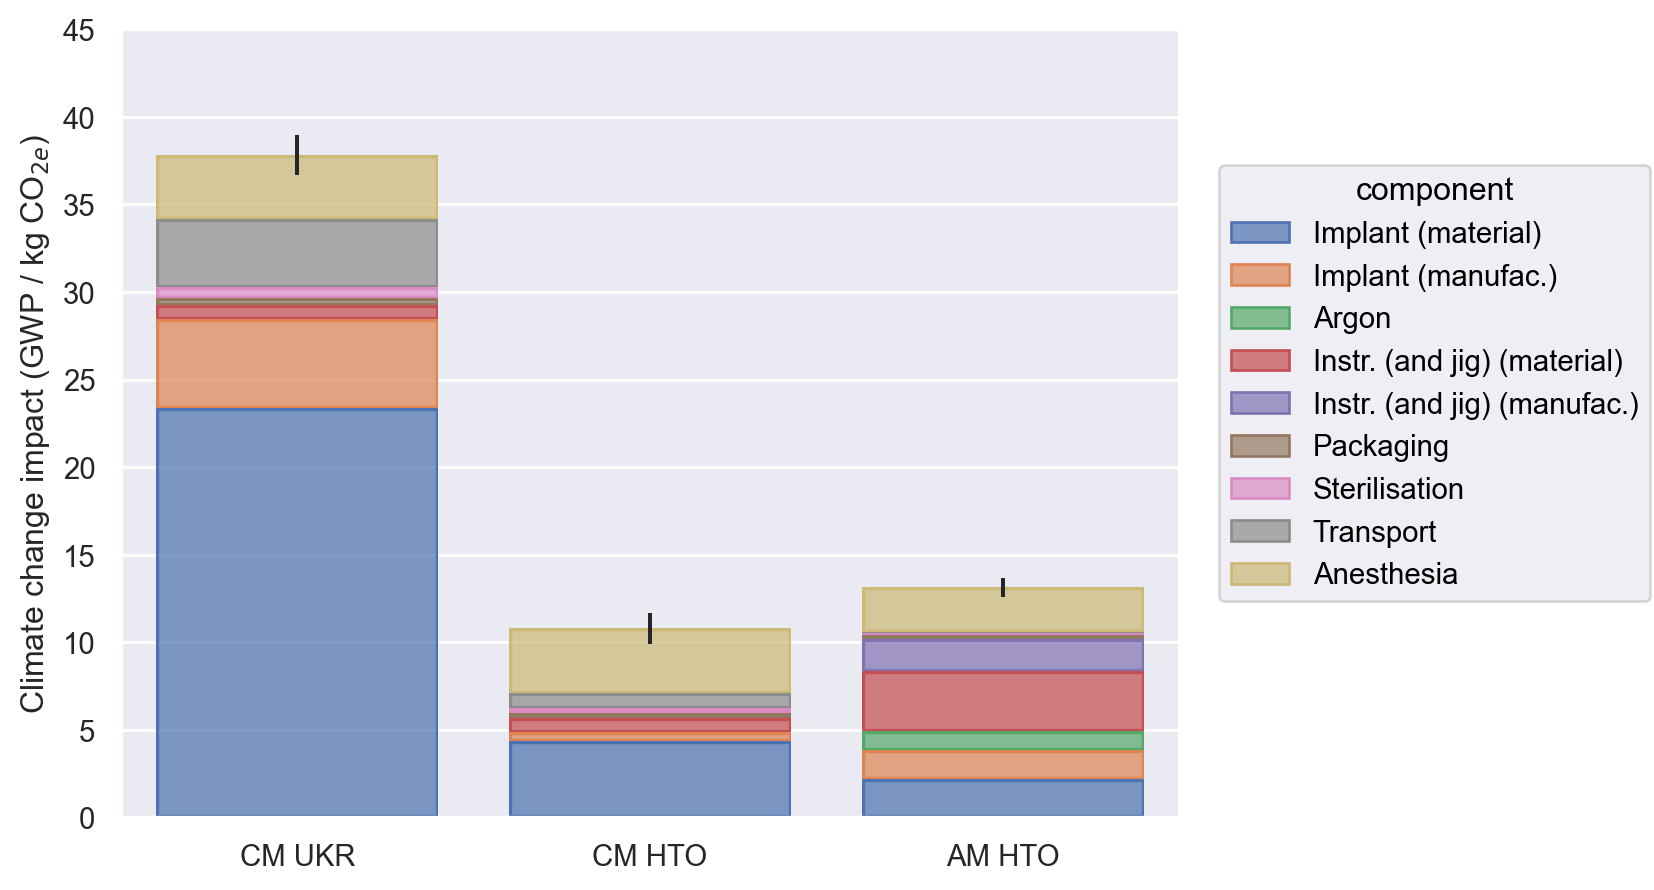

In [65]:
baseline= baseline[baseline['component'] != 'Total']
(
    so.Plot(baseline, x="scenario", y="score")
    .add(so.Bar(), so.Agg(), so.Stack(), color="component")
    .add(so.Range(color='k'), so.Est(errorbar=("pi", 50)),
         data=baseline.groupby(["scenario", "iteration"], as_index=False)["score"].sum())
    .label(x="", y="Climate change impact (GWP / kg CO$_{2e}$)")
    .limit(y=(0, 45))
    .save("figures/overall_gwp_comparison_contributions.pdf", bbox_inches="tight")
)

## Relative GWPs (relative to CM HTO)

Normalise scores to compare to CM HTO.  Since all devices' impacts are calculated together for each sample, this checks for correlations which affect the comparison.

To do this, aggregate out the components, since they are not the same for the different devices.

In [48]:
df = samples_combined.groupby(["scenario", "energy_scenario", "method", "iteration"])["score"].sum()
relative = pd.concat({
    (scenario, energy_scenario): df.loc[scenario, energy_scenario] / df.loc["CM HTO", "Current"]
    for scenario in samples_combined["scenario"].unique()
    for energy_scenario in samples_combined["energy_scenario"].unique()
    if (scenario, energy_scenario) not in [("UKR", "Greener"), ("CM HTO", "Greener")]
}, axis=0, names=["scenario", "energy_scenario"]).reset_index()
relative["combined_scenario"] = relative["scenario"] + "\n" + relative["energy_scenario"]
relative.to_csv("results/relative_gwp_contributions.csv", index=False)
relative

,scenario,energy_scenario,method,iteration,score,combined_scenario
0,UKR,Current,climate change,0,3.298442,UKR\nCurrent
1,UKR,Current,climate change,1,3.417464,UKR\nCurrent
2,UKR,Current,climate change,2,3.159718,UKR\nCurrent
3,UKR,Current,climate change,3,3.168568,UKR\nCurrent
4,UKR,Current,climate change,4,3.459450,UKR\nCurrent
...,...,...,...,...,...,...
5995,AM HTO (steel jig),Greener,climate change,995,0.832457,AM HTO (steel jig)\nGreener
5996,AM HTO (steel jig),Greener,climate change,996,0.851471,AM HTO (steel jig)\nGreener
5997,AM HTO (steel jig),Greener,climate change,997,0.775334,AM HTO (steel jig)\nGreener
5998,AM HTO (steel jig),Greener,climate change,998,0.875038,AM HTO (steel jig)\nGreener


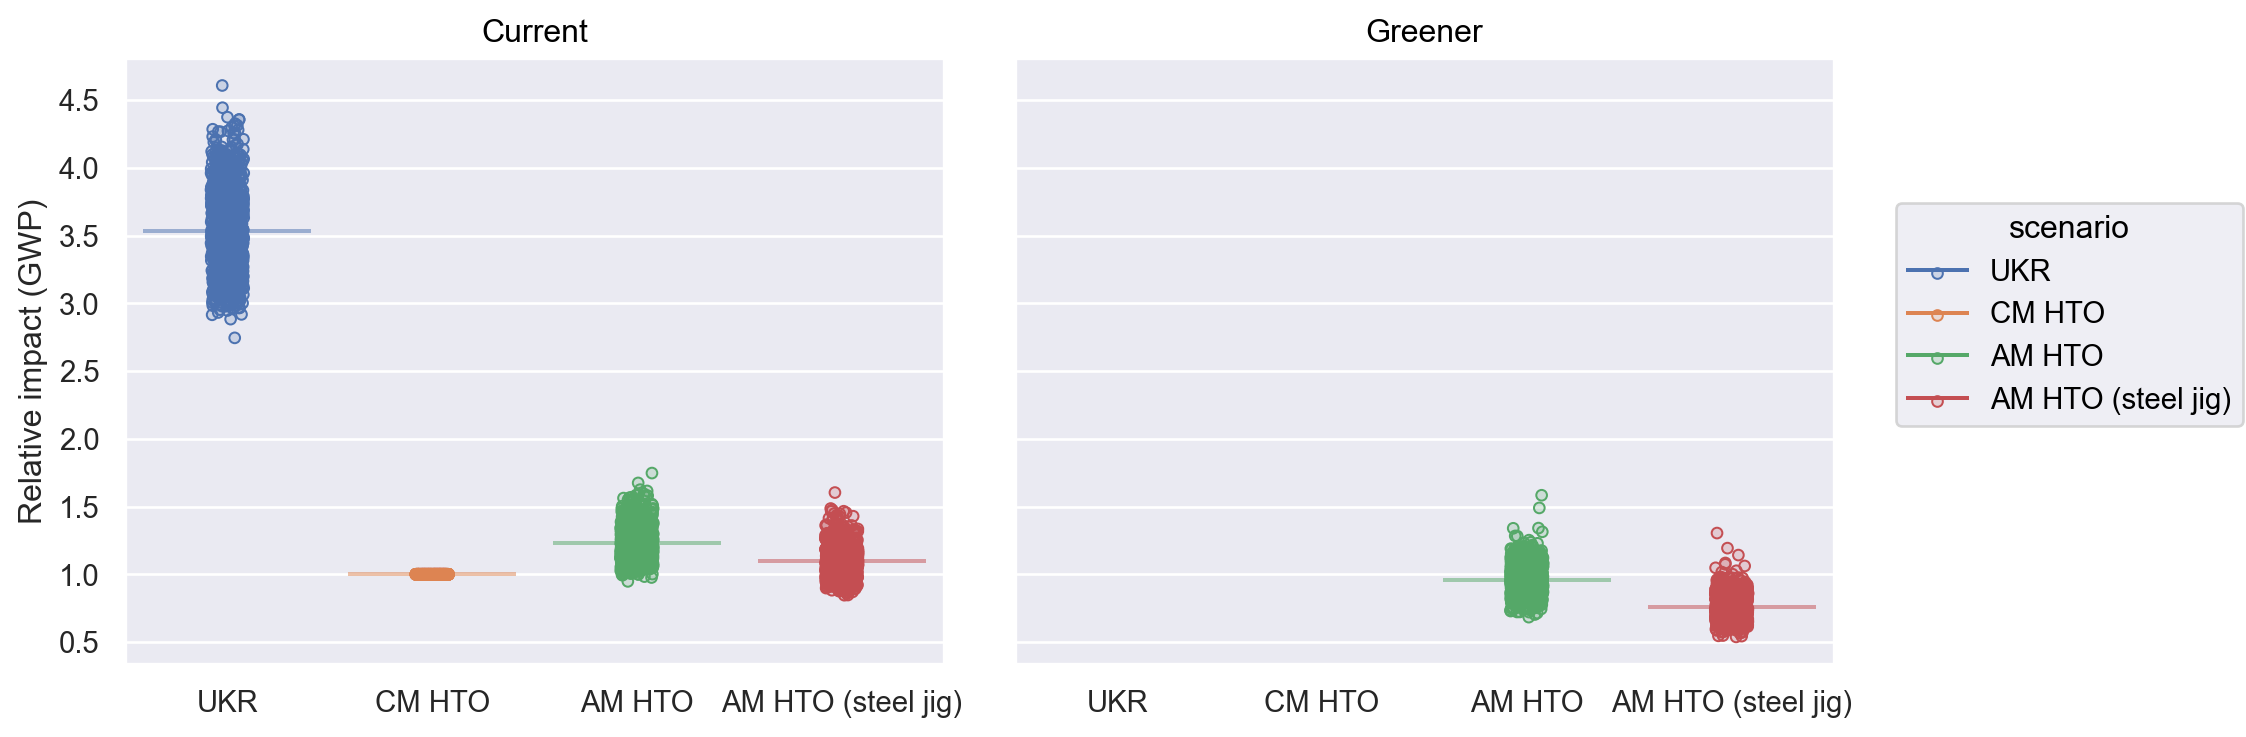

In [49]:
(
    so.Plot(relative, x="scenario", y="score", color="scenario")
    .layout(size=(10, 4))
    .facet(col="energy_scenario")
    .add(so.Dash(alpha=0.5), so.Agg())
    .add(so.Dots(), so.Jitter())
    .label(
        x="",
        y="Relative impact (GWP)"
    )
)

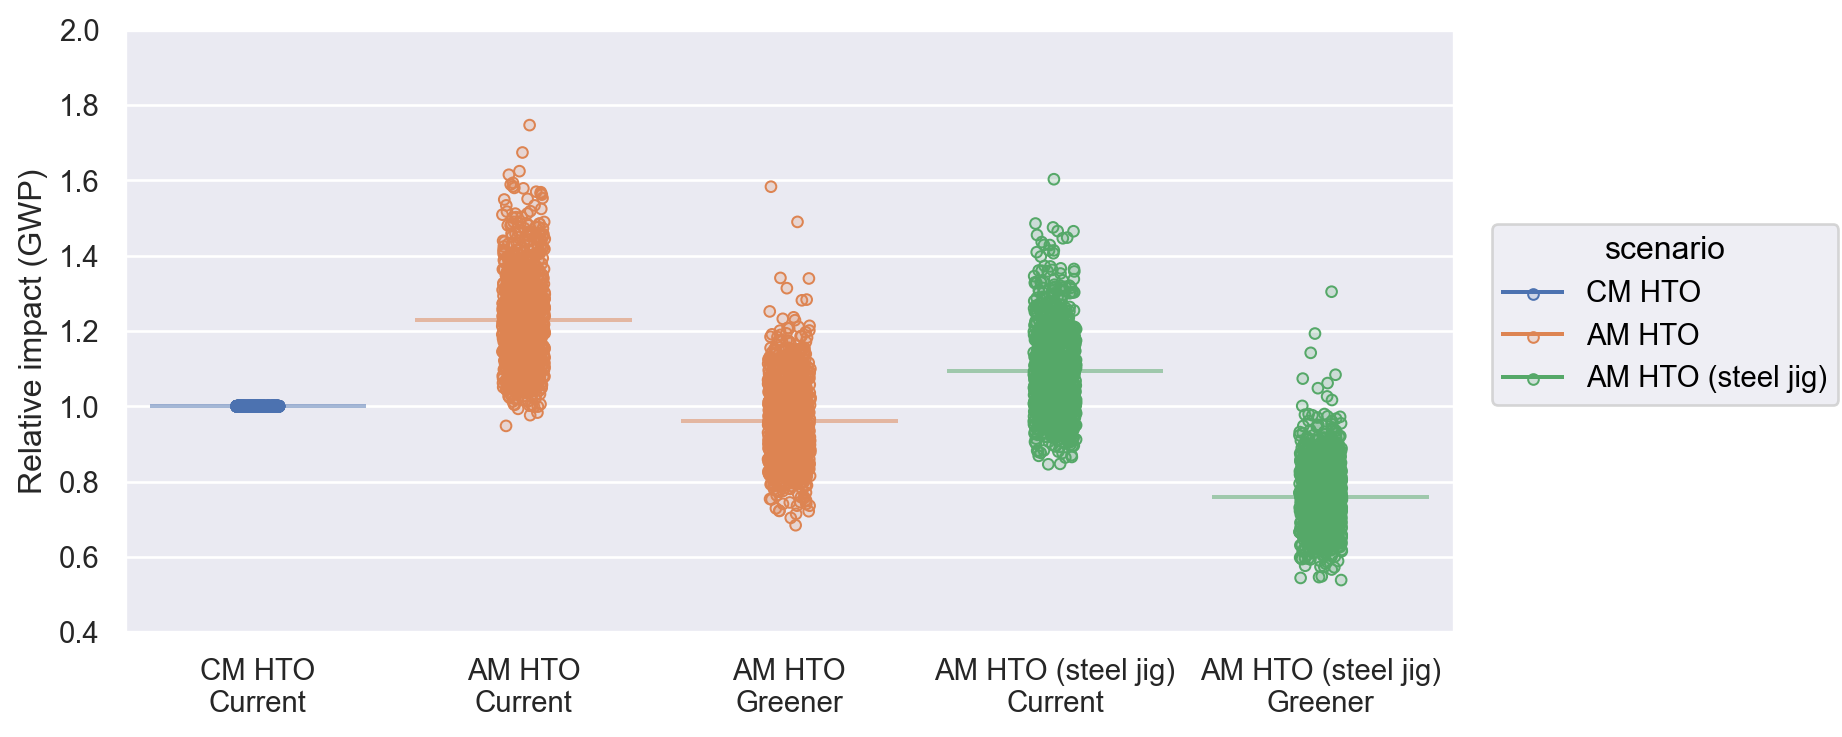

In [50]:
(
    so.Plot(relative.query('scenario != "UKR"'), x="combined_scenario", y="score", color="scenario")
    .layout(size=(7.85, 4))
    .add(so.Dash(alpha=0.5), so.Agg())
    .add(so.Dots(), so.Jitter())
    .label(
        x="",
        y="Relative impact (GWP)"
    )
    .limit(y=(0.4, 2))
   # .save("figures/relative_gwp_scenarios.pdf", bbox_inches=mpl.transforms.Bbox.from_extents(0, 0, 7.75, 4))
)

This shows clearly that even though the absolute impact ranges of the CM and AM HTOs overlap, the AM HTO in the baseline scenario always has a higher impact.

In [51]:
wide = df.unstack(level="scenario")
wide.head(3)

scenario                                     AM HTO  AM HTO (steel jig)  \
energy_scenario method         iteration                                  
Current         climate change 0          13.715287           12.142817   
                               1          13.668985           12.618474   
                               2          13.740172           12.517542   

scenario                                     CM HTO        UKR  
energy_scenario method         iteration                        
Current         climate change 0          11.277629  37.198604  
                               1          11.648030  39.806719  
                               2          11.723336  37.042432

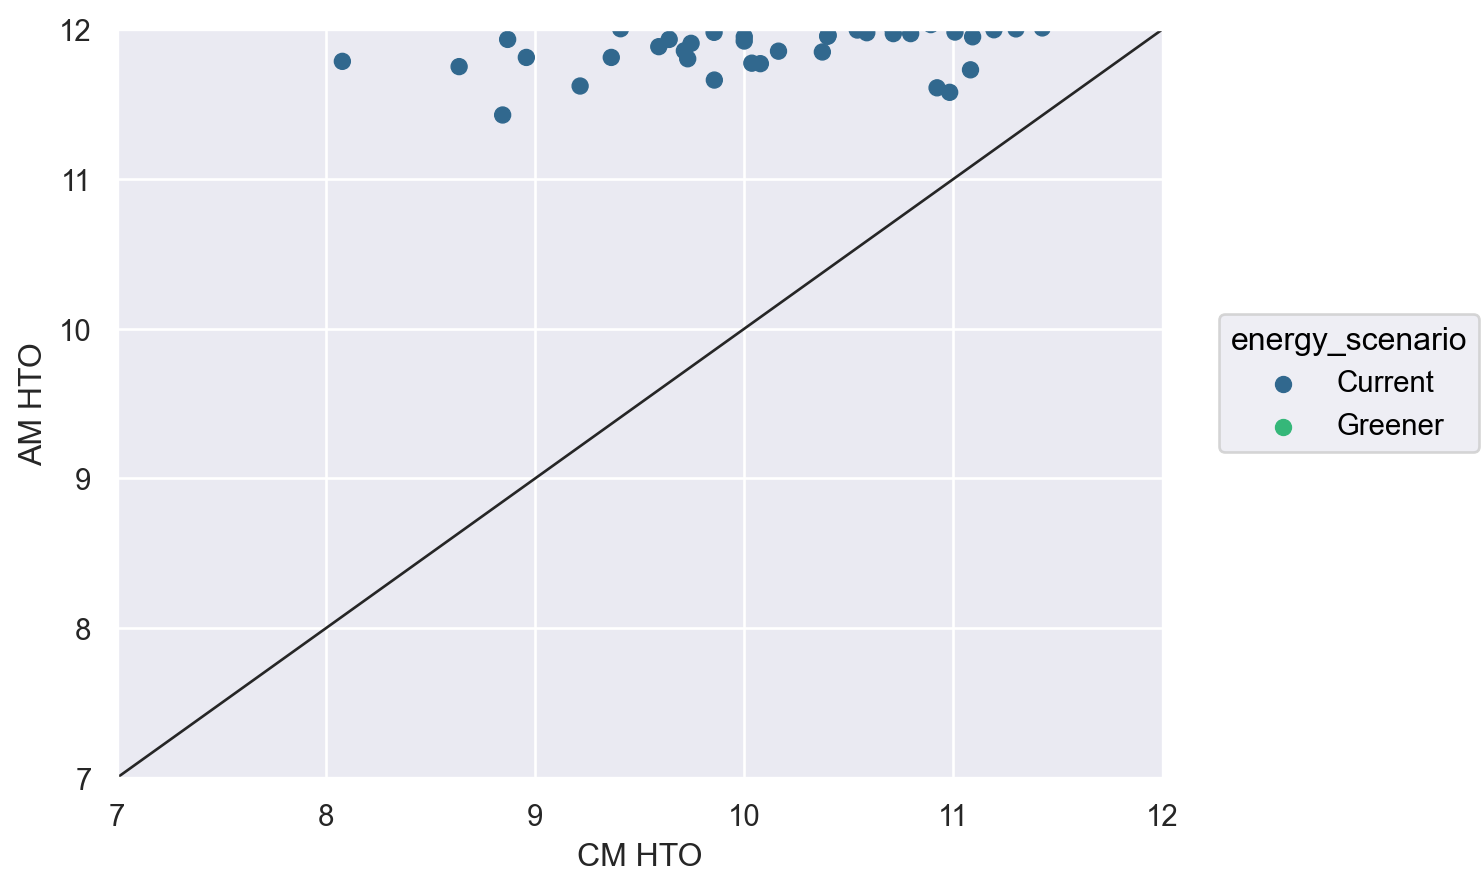

In [52]:
(
    so.Plot(wide.reset_index(), x="CM HTO", y="AM HTO", color="energy_scenario")
    .add(so.Dot())
    .add(so.Line(color='k', linewidth=1), x="x", y="y", data={"x": [7, 12], "y": [7, 12]}, color=None)
    .limit(
        x=(7, 12),
        y=(7, 12),
    )
    .scale(
        color="viridis"
    )
)

## Uncertainty in contribution analysis

This is a more complicated figure, but it shows clearly what's changing between the scenarios and where the uncertainty is.

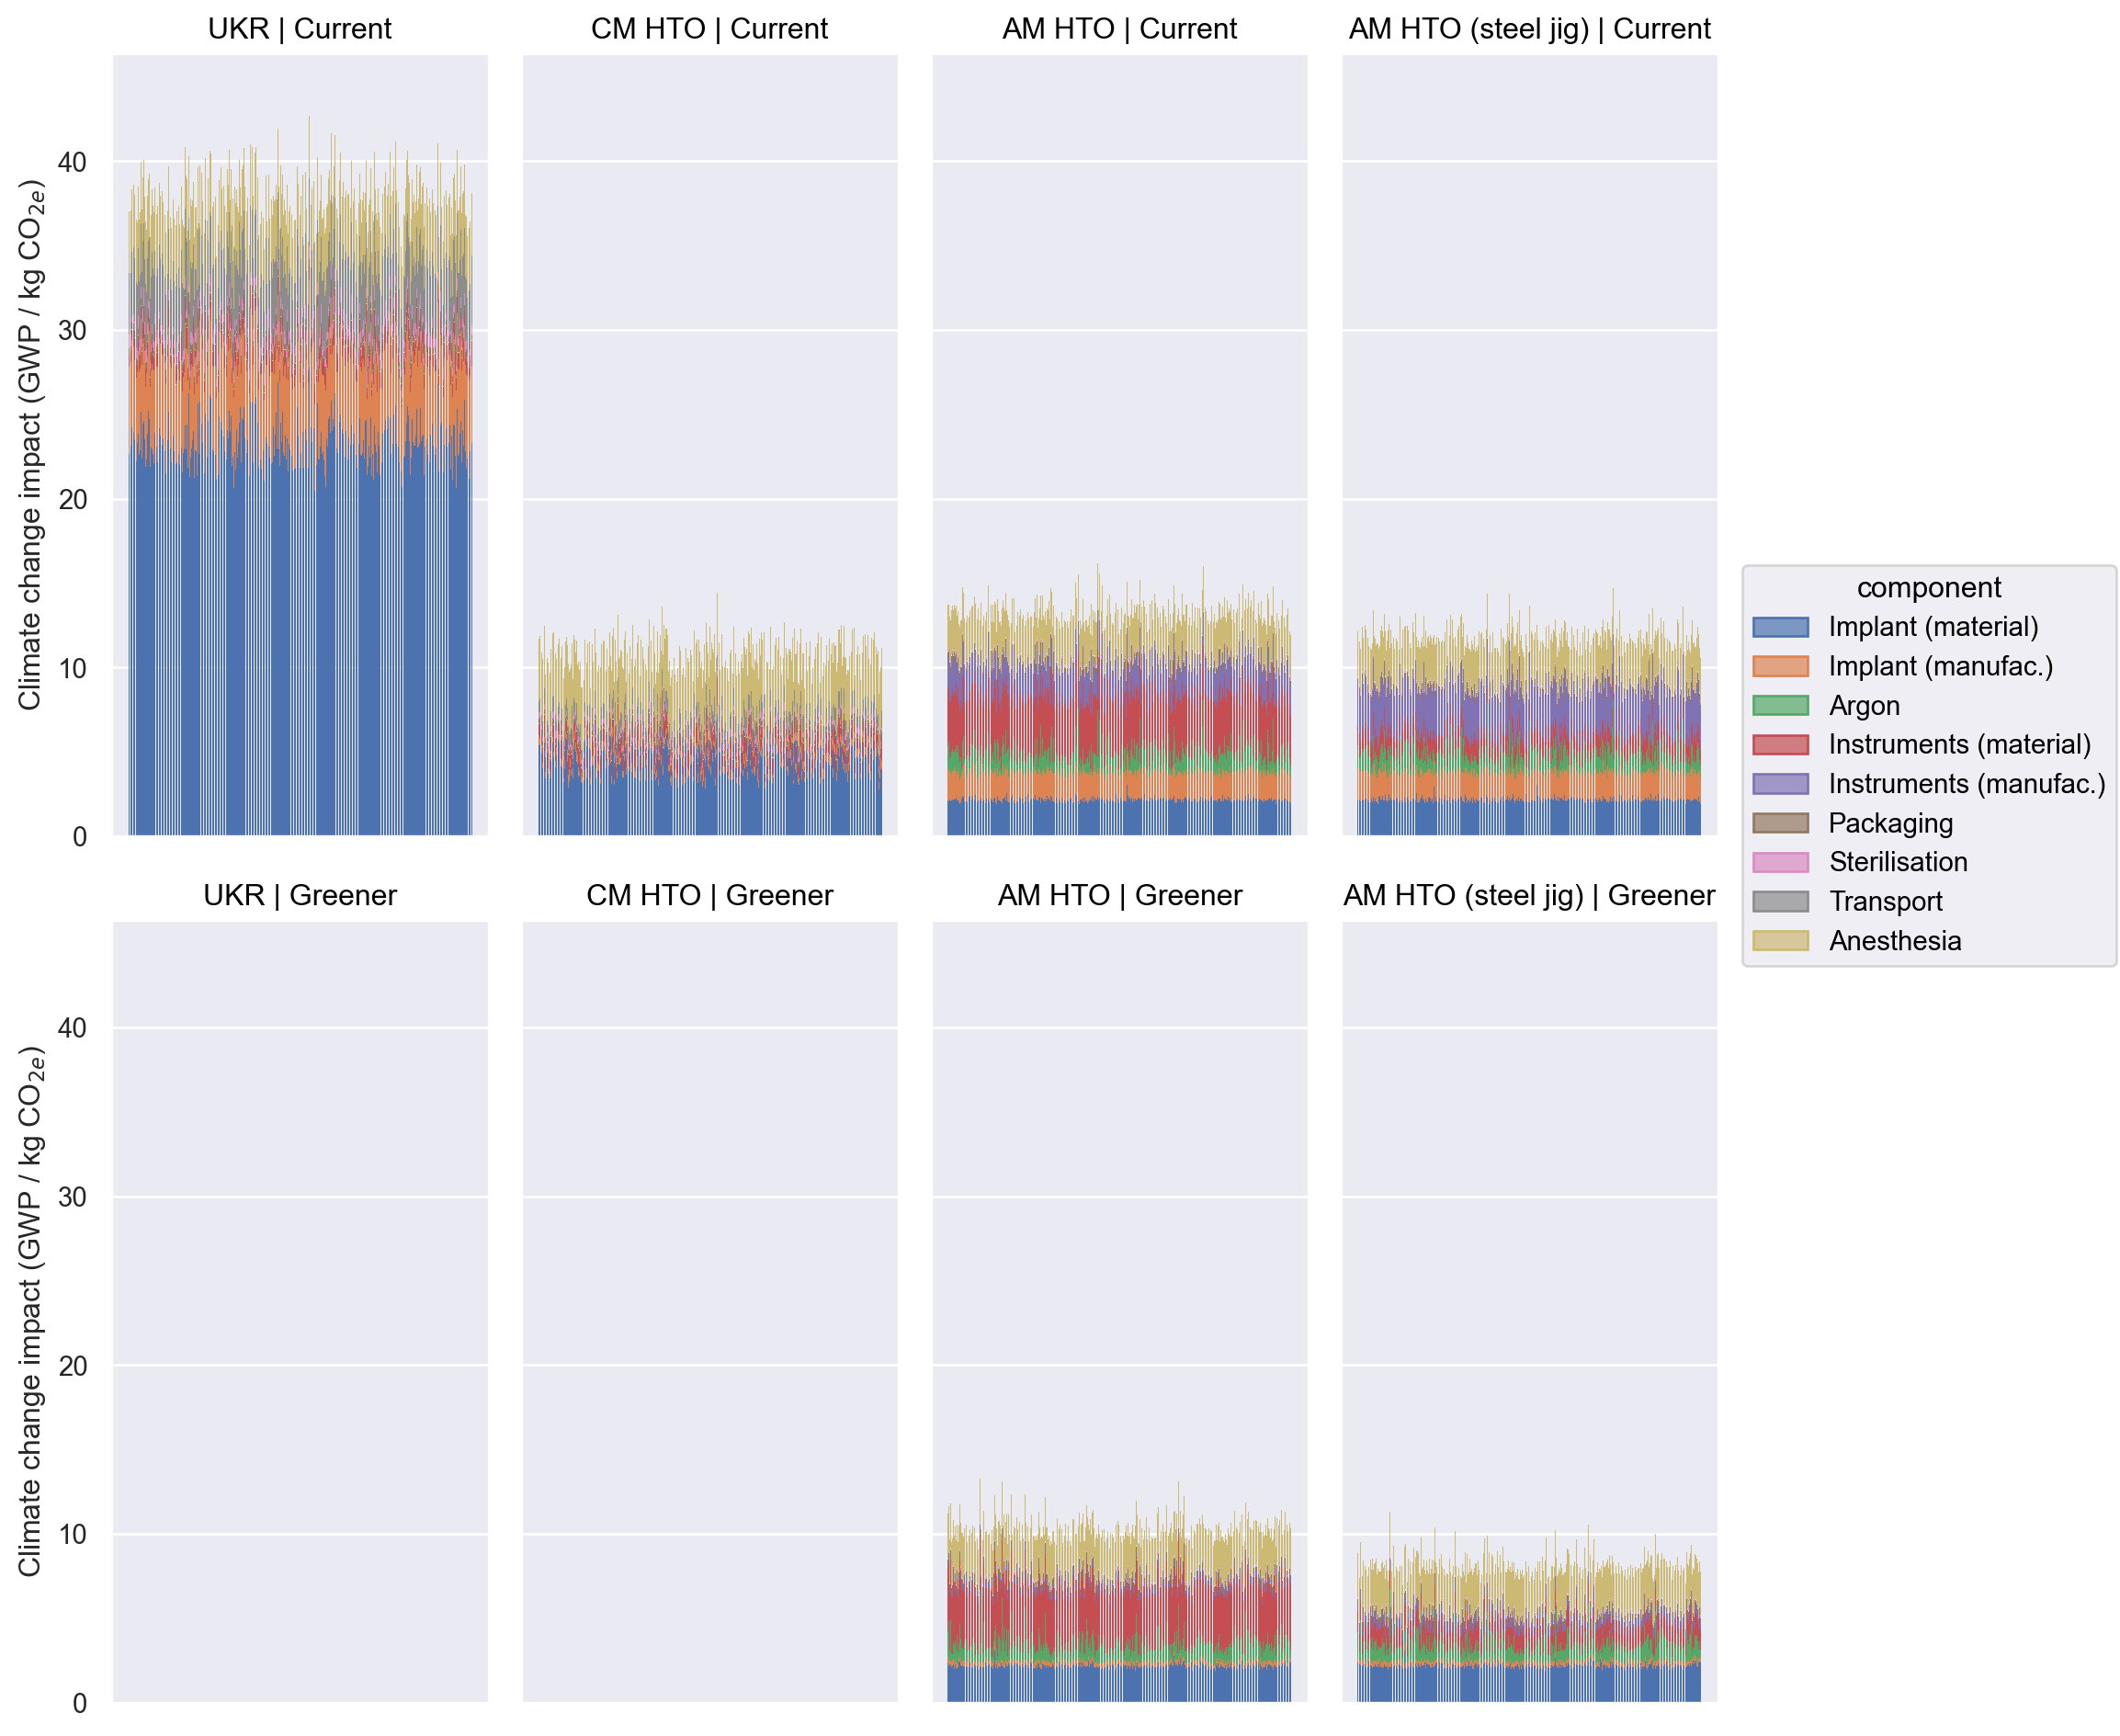

In [53]:
(
    so.Plot(samples_combined, x="iteration", y="score", color="component")
    .facet(row="energy_scenario", col="scenario")
    .layout(size=(10, 10))
    .add(so.Bar(), so.Stack())
    .scale(
        x=so.Continuous().tick(at=[]),
    )
    .label(
        x="",
        y="Climate change impact (GWP / kg CO$_{2e}$)"
    )
)

## Other impact categories

In [54]:
method_units = {
    'acidification: terrestrial': 'kg SO$_2$ eq',
    'climate change': 'kg CO$_2$ eq',
    'ecotoxicity: freshwater': 'kg 1.4 DCB eq',
    'ecotoxicity: marine': 'kg 1.4 DCB eq',
    'ecotoxicity: terrestrial': 'kg 1.4 DCB eq',
    'energy resources: non-renewable, fossil': 'kg oil eq',
    'eutrophication: freshwater': 'kg P eq',
    'eutrophication: marine': 'kg N eq',
    'human toxicity: carcinogenic': 'kg 1.4 DCB eq',
    'human toxicity: non-carcinogenic': 'kg 1.4 DCB eq',
    'ionising radiation': 'kg CO 60 eq',
    'land use': 'm$^2$a crop eq',
    'material resources: metals/minerals': 'kg Cu eq',
    'ozone depletion': 'kg CFC 11 eq',
    'particulate matter formation': 'kg PM2.5 eq',
    'photochemical oxidant formation: human health': 'kg NOx eq',
    'photochemical oxidant formation: terrestrial ecosystems': 'kg NOx eq',
    'water use': 'm$^3$'
}

def format_score(score, method):
    """Format an imact score with appropriate units"""
    if score >= 1e-2:
        return f"{score:.2f}\n{method_units[method]}"
    else:
        return f"{score:.2g}\n{method_units[method]}"

In [58]:
contribs = pd.read_csv("results/all_impact_category_contributions.csv")
contribs['component'] = contribs['component'].replace('Instruments (material)', 'Instr. (and jig) (material)')
contribs['component'] = contribs['component'].replace('Instruments (manufac.)', 'Instr. (and jig) (manufac.)')


# Add label to the top component -- bit messy but including the aggregation directly doesn't seem to work
total_contribs = contribs.groupby(["method", "device"]).sum(numeric_only=True)
contribs.loc[:, "label"] = contribs.apply(
    lambda row: format_score(total_contribs["score"].loc[row["method"], row["device"]], row["method"]) if row["component"] == "Anesthesia" else "",
    axis=1
)
contribs.loc[:, "label_y"] = contribs.apply(
    lambda row: total_contribs["normalised_score"].loc[row["method"], row["device"]] if row["component"] == "Anesthesia" else 0,
    axis=1
)
#contribs.loc[contribs["component"] == "Anesthesia", "label"] = contribs.loc[contribs["component"] == "Anesthesia", "score"].map("{:.2f}".format)

In [59]:
contribs

,method,component,score,device,normalised_score,label,label_y
0,acidification: terrestrial,Implant (material),1.566226e-02,CM HTO,0.665716,,0.000000
1,climate change,Implant (material),4.008664e+00,CM HTO,0.392109,,0.000000
2,ecotoxicity: freshwater,Implant (material),3.246248e-01,CM HTO,0.733401,,0.000000
3,ecotoxicity: marine,Implant (material),4.535347e-01,CM HTO,0.735515,,0.000000
4,ecotoxicity: terrestrial,Implant (material),7.366651e+00,CM HTO,0.229259,,0.000000
...,...,...,...,...,...,...,...
481,ozone depletion,Anesthesia,3.336679e-07,UKR,0.119345,1.9e-05\nkg CFC 11 eq,6.963217
482,particulate matter formation,Anesthesia,4.134676e-04,UKR,0.036075,0.07\nkg PM2.5 eq,5.691541
483,photochemical oxidant formation: human health,Anesthesia,1.025534e-03,UKR,0.059342,0.08\nkg NOx eq,4.842117
484,photochemical oxidant formation: terrestrial e...,Anesthesia,1.035459e-03,UKR,0.059117,0.09\nkg NOx eq,4.856500


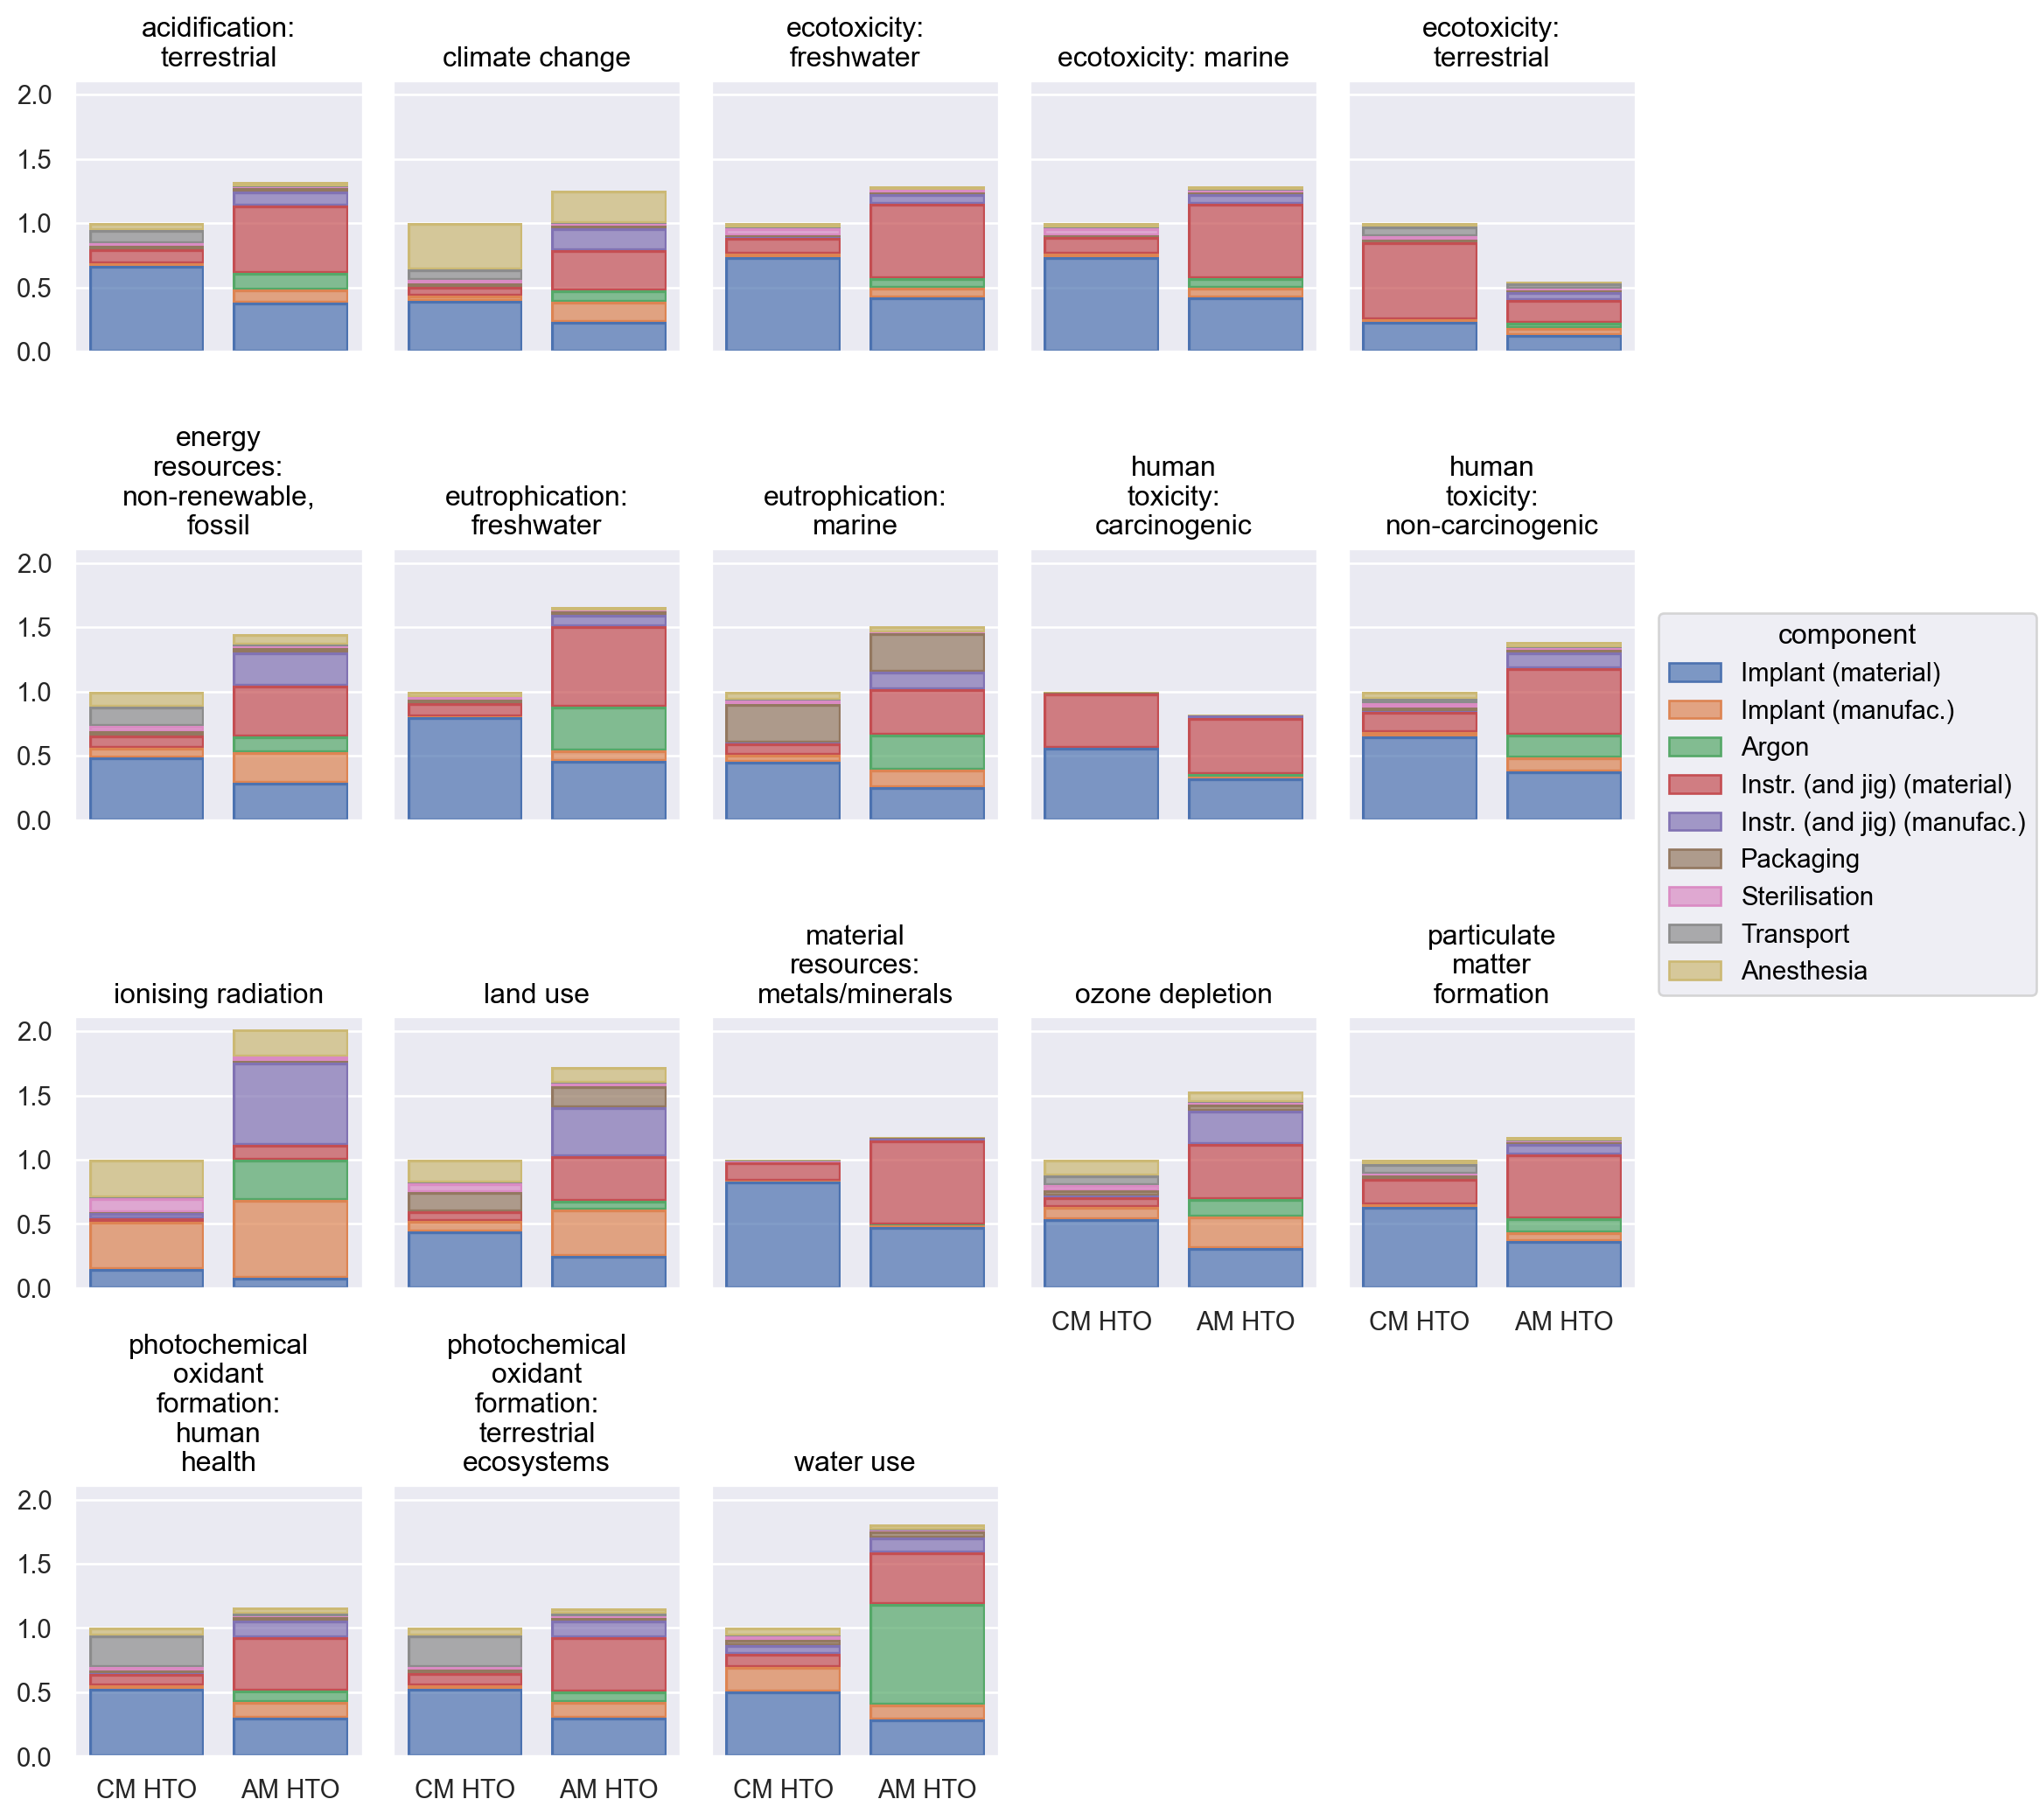

In [61]:
import warnings
warnings.filterwarnings('ignore')
contribs =  contribs[contribs['device'] != 'UKR']
(
    so.Plot(contribs, x="device", y="normalised_score")
    .layout(size=(10, 11))
    .facet(col="method", wrap=5)
    .add(so.Bar(), so.Stack(), color="component")
    #.add(so.Text(halign="center", valign="bottom"), text="label", y="label_y")
    .label(y="", x="",
           title=lambda x: x.replace(" ", "\n") if len(x) > 20 else x)
    .save("figures/all_impact_contributions.pdf", bbox_inches="tight")
)